# Paper Id : Year = 2019 & Data Type = Journal

In [67]:
import pandas as pd
import numpy as np
import pickle

In [2]:
import matplotlib.pyplot as plt

In [9]:
paper_id = pd.read_csv('../../../Data/Sample/PAPERID_JOURNAL_SAMPLE.csv')

In [48]:
paper_id

,PaperId
0,2187741008
1,2191294727
2,2412796382
3,2565919305
4,2568408079
...,...
19995,3025443597
19996,3163234662
19997,2729208034
19998,2806925393


# Author 

In [11]:
Paperid_author_df = pd.read_csv('../../../Data/Sample/PaperAuthorAffiliation_2019_sample.csv')

In [12]:
Paperid_author_df

,PaperId,AuthorId,AffiliationId,AuthorSequenceNumber,OriginalAuthor,OriginalAffiliation
0,71159355,1964447378,1174212.0,3,Ira A. Shulman,"Department of Pathology, Los Angeles County-Un..."
1,71159355,2045999286,1174212.0,4,Vinod Pullarkat,"Jane Anne Nohl Division of Hematology, Keck Sc..."
2,71159355,2500271631,1174212.0,2,Preeti Chaudhary,"Jane Anne Nohl Division of Hematology, Keck Sc..."
3,71159355,2512594524,1174212.0,1,Miriam Y. Kim,"Jane Anne Nohl Division of Hematology, Keck Sc..."
4,187709788,2127608439,NaN,1,B.J. Edwards,NaN
...,...,...,...,...,...,...
109784,3204400846,3050649188,NaN,4,D Singh,NaN
109785,3204400846,3055678791,NaN,3,DK Samadia,NaN
109786,3204400846,3152601463,NaN,2,BR Choudhary,NaN
109787,3204881130,1514884828,NaN,2,K. Vijayalakshmi,"Ramco Institute of Technology, Rajapalayam"


# Vectors

In [14]:
vectors = np.load('../../../Data/Sample/sBERT_JOURNAL_SAMPLE.npy',allow_pickle=True)

In [49]:
paperid_vector_dict = dict(zip(paper_id['PaperId'], vectors))

# Matching field to papers

In [18]:
l = ['PaperId','FieldId','Score']

In [20]:
PaperId_FieldId_df = pd.read_csv('../../../Data/Sample/PaperId_FieldId_Level_Sample.csv')

In [37]:
PaperId_FieldId_df = PaperId_FieldId_df[PaperId_FieldId_df['Score']!=0]

In [22]:
from tqdm import tqdm

In [25]:
l = PaperId_FieldId_df[PaperId_FieldId_df['Level']==1].groupby(['NormalizedName']).count()

In [29]:
l

,PaperId,FieldId,Score,Level
NormalizedName,,,,
accounting,46,46,46,46
acoustics,79,79,79,79
actuarial science,24,24,24,24
advertising,39,39,39,39
aeronautics,4,4,4,4
...,...,...,...,...
waste management,37,37,37,37
water resource management,22,22,22,22
welfare economics,15,15,15,15


In [55]:
Normalizedname_level1_set = set(l[l['PaperId']>100].index)

In [50]:
Normalizedname_Paperid ={}

for key,value in tqdm(zip(PaperId_FieldId_df['NormalizedName'],PaperId_FieldId_df['PaperId'])):
    if key not in Normalizedname_Paperid:
        Normalizedname_Paperid[key]=[value]
    else:
        Normalizedname_Paperid[key].append(value)



166618it [00:00, 622832.35it/s]


In [52]:
Normalizedname_level1_Meanvector = {}
for key in tqdm(Normalizedname_level1_set):
    if len(Normalizedname_Paperid[key])<100:
        continue
    else:
        Normalizedname_level1_Meanvector[key] = np.mean([paperid_vector_dict[x] for x in Normalizedname_Paperid[key] ],axis=0)
        

100%|██████████| 246/246 [00:00<00:00, 4313.41it/s]


In [53]:
from scipy.spatial import distance

In [56]:
Cosine_distance = {}
for normalize_name in tqdm(Normalizedname_level1_set):
    normalize_name_cosine={}
    mean_vector = Normalizedname_level1_Meanvector[normalize_name]
    for paperid in Normalizedname_Paperid[normalize_name]:
        normalize_name_cosine[paperid] = distance.cosine(mean_vector,paperid_vector_dict[paperid])
    Cosine_distance[normalize_name] = normalize_name_cosine
  

100%|██████████| 60/60 [00:00<00:00, 141.60it/s]


In [57]:
paperid_numbauthor = Paperid_author_df.groupby(['PaperId']).count()['AuthorId']

# Regression

In [58]:
import statsmodels.formula.api as smf

In [59]:
from tqdm import tqdm

In [63]:
Result = []
for name in tqdm(Cosine_distance):
    
    Cosine_distance_df = pd.DataFrame(Cosine_distance[name].items(),columns=['PaperId','Cosine_Distance'])
    
    if len(Cosine_distance_df)<100:
        continue
    
    Cosine_distance_df = Cosine_distance_df[Cosine_distance_df['PaperId'].apply(lambda x: True if x in paperid_numbauthor.index else False)]
    Cosine_distance_df['Numberofauth']=Cosine_distance_df['PaperId'].apply(lambda x: paperid_numbauthor[x])
    
    
    
    threshold = Cosine_distance_df['Numberofauth'].quantile(0.99) 
    print(name, threshold)
    Cosine_distance_df = Cosine_distance_df[Cosine_distance_df['Numberofauth'].apply(lambda x: True if x<threshold+1 else False)]
    
    mean_author = Cosine_distance_df['Numberofauth'].mean()
    
    mod = smf.ols(formula='Cosine_Distance ~ Numberofauth', data=Cosine_distance_df)

    res = mod.fit()
    

    Result.append({"NormalizedName" :name,'NumberofAuth Coefficient': res.params['Numberofauth'],'NumberofAuth pvalue':  res.pvalues['Numberofauth'],"Mean author":mean_author, "Observations": len(Cosine_distance_df),"Rsquared": res.rsquared_adj})
    
    
    
    

  3%|▎         | 2/60 [00:00<00:03, 17.75it/s]

ecology 15.899999999999977
food science 14.029999999999973
zoology 13.199999999999989
combinatorics 7.689999999999998
computational biology 25.5
control theory 8.509999999999991
humanities 7.439999999999998
microbiology 17.519999999999982
molecular biology 29.579999999999984
optoelectronics 16.460000000000008
radiology 21.860000000000014


 33%|███▎      | 20/60 [00:00<00:01, 29.50it/s]

public relations 8.0
biochemistry 16.120000000000005
optics 23.68999999999997
nanotechnology 16.439999999999998
nuclear chemistry 11.860000000000014
social psychology 6.0
environmental health 18.69999999999999
horticulture 13.279999999999973
chemical engineering 13.0
composite material 11.0
analytical chemistry 14.129999999999995
emergency medicine 24.0
mathematics education 7.849999999999994
physical therapy 22.610000000000213
pure mathematics 5.0
medical education 9.310000000000002
astrophysics 36.95999999999998


 75%|███████▌  | 45/60 [00:00<00:00, 50.95it/s]

cancer research 32.299999999999955
gastroenterology 24.539999999999964
algorithm 10.939999999999998
internal medicine 44.039999999999964
cell biology 21.0
mechanics 8.399999999999977
nursing 14.849999999999994
environmental chemistry 19.099999999999966
anesthesia 29.75
family medicine 20.810000000000002
combinatorial chemistry 12.799999999999997
applied mathematics 5.609999999999985
chromatography 13.0
pathology 39.849999999999966
developmental psychology 11.849999999999994
genetics 19.779999999999973
machine learning 17.130000000000067
surgery 18.379999999999995


100%|██████████| 60/60 [00:00<00:00, 72.81it/s]

clinical psychology 17.0
oncology 34.0
demography 20.400000000000034
neuroscience 18.43999999999997
intensive care medicine 34.49000000000001
biophysics 15.95999999999998
cardiology 20.480000000000018
immunology 20.560000000000002
endocrinology 18.67999999999995
pattern recognition 11.829999999999956
pediatrics 18.289999999999992
animal science 13.819999999999993
pharmacology 26.599999999999994
condensed matter physics 21.0


In [64]:
Result = pd.DataFrame(Result)

In [65]:
Result

,NormalizedName,NumberofAuth Coefficient,NumberofAuth pvalue,Mean author,Observations,Rsquared
0,ecology,0.001137,4.674861e-01,5.024845,161,-0.002943
1,food science,0.003212,3.371767e-02,5.580808,198,0.017814
2,zoology,0.005493,4.810552e-05,5.071429,140,0.106787
3,combinatorics,0.005036,5.562503e-02,2.312977,131,0.020571
4,computational biology,-0.001831,5.241483e-02,5.771812,149,0.018725
5,control theory,0.004525,3.494453e-02,3.885906,149,0.023305
6,humanities,0.029174,8.539990e-13,1.878981,157,0.277206
7,microbiology,0.001096,4.241748e-01,6.544118,136,-0.002654
8,molecular biology,-0.000581,5.429275e-01,7.273585,106,-0.006011
9,optoelectronics,-0.002648,8.597503e-04,6.581028,253,0.039561


Text(0.5, 1.0, '99 percentile')

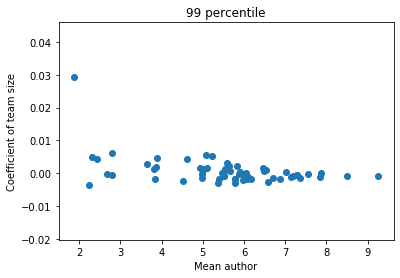

In [66]:
plt.scatter(Result['Mean author'],Result['NumberofAuth Coefficient'])
plt.xlabel('Mean author')
plt.ylabel('Coefficient of team size')
plt.title('99 percentile')